<a href="https://colab.research.google.com/github/airesx2/cudaq/blob/main/quick-start-to-quantum/04_quick_start_to_quantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
!pip install cudaq

# Quick start to Quantum Computing with CUDA-Q
# Lab 4 - Converge on a Solution: Write your first hybrid variational program
$
\renewcommand{\ket}[1]{|{#1}\rangle}
\renewcommand{\bra}[1]{\langle{#1}|}
$

Labs 3 and 4 break the hybrid variational algorithm into four steps.  In the first notebook (lab 3), we cover sections 1 and 2.  The second notebook (lab 4) covers the remaining sections.
* Section 1: Comparing Classical Random Walks and Discrete Time Quantum Walk (DTQW)
* Section 2: Programming a variational DTQW with CUDA-Q
* Section 3: Defining Hamiltonians and Computing Expectation Values  
* Section 4: Identify Parameters to Generate a Targeted Mean Value

In Lab 3, we coded the parameterized kernel for the discrete time quantum walk (DTQW) using `cudaq`.  In this notebook, we'll compute expectation values and use a classical optimizer to identify parameters to optimize a cost function, completing the coding of the diagram below:

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/dtqw-diagram.png" alt="image of a variational discrete time quantum walk" width="700"/>


**What you'll do:**
* Define and visualize Discrete Time Quantum Walks for generating probability distributions
* Add variational gates for the coin operators to create your first variational program
* Construct a Hamiltonian that can be used to compute the average of the probability distribution generated by a quantum walk
* Use a classical optimizer to identify optimal parameters in the variational quantum walk that will generate a distribution with a targeted average value

**Terminology you'll use:**

* Computational basis states (basis states for short)
* Probability amplitude
* Statevector
* Control and target for multi-qubit controlled-operations
* Hamiltonian
* Pauli-Z operator

**CUDA-Q syntax you'll use:**
* quantum kernel function decoration: `@cudaq.kernel`
* qubit initialization: `cudaq.qvector` and `cudaq.qubit`
* quantum gates: `x`, `h`, `t`, _`.ctrl`, `cudaq.register_operation`, `u3`
* spin operators: `spin.z`, `spin.i`
* extract information from a kernel: `sample`, `get_state`, _`.amplitude`, `observe`
* optimize parameters in a variational quantum algorithm: `cudaq.optimizers`


Let's begin by installing the necessary packages.

In [1]:
import cudaq
import numpy as np
import matplotlib.pyplot as plt

We've copied over the functions from Lab 3.1 that we'll need here.  Make sure you execute this cell below before continuing.

In [2]:
# Define a kernel on 4 qubits for the INC operation that
# maps |x> to |x+1> mod 16

@cudaq.kernel
def INC(qubits : cudaq.qview):
    x.ctrl([qubits[3], qubits[2], qubits[1]], qubits[0])
    x.ctrl([qubits[3], qubits[2]], qubits[1])
    x.ctrl(qubits[3], qubits[2])
    x(qubits[3])


# Define a kernel on 4 qubits for the DEC operation that
# maps |x> to |x-1> mod 16

@cudaq.kernel
def DEC(qubits : cudaq.qview):
    x.ctrl(qubits[3], qubits[2])
    x.ctrl([qubits[3], qubits[2]], qubits[1])
    x.ctrl([qubits[3], qubits[2], qubits[1]], qubits[0])


---
## **Section 3** Defining Hamiltonians and Computing Expectation Values

(Sections 1 and 2 can be found in Lab 3)

A significant challenge in quantum computing is the efficient encoding of classical data into quantum states that can be processed by quantum hardware or simulated on classical computers. This is particularly crucial for many financial applications, where the first step of a quantum algorithm often involves efficiently loading a probability distribution. For instance, to enable lenders to price loans more accurately based on each borrower's unique risk profile, it is essential to estimate individual loan risk distributions (such as default and prepayment) while accounting for uncertainties in modeling and macroeconomic factors. Efficiently implementing this process on a quantum computer requires the ability to load a log-normal or other complex distribution into a quantum state [(Breeden and Leonova)](https://www.tandfonline.com/doi/full/10.1080/01605682.2022.2115415).

Financial markets exhibit complex probability distributions and multi-agent interactions that classical models struggle to capture efficiently. Quantum walks can be used to generate probability distributions of market data. The quantum walk approach offers:
* Flexible modeling of price movements
* Better representation of extreme events compared to classical methods
* Ability to capture asymmetric return distributions [(Backer et al)](https://arxiv.org/pdf/2403.19502).

### The Problem

This tutorial explores how to load a probability distribution with a given property (in this case, a fixed mean) into a quantum state. By following this example, you will gain the essential knowledge needed to comprehend more sophisticated algorithms, such as the multi-split-step quantum walks (mSSQW) method, as described by  [Chang et al.](https://arxiv.org/pdf/2302.12500) The mSSQW technique can be employed to load a log-normal distribution, which is useful for modeling the spot price of a financial asset at maturity.

**Pedagogical Remark:** The reason why we chose to examine the courser problem of generating a distribution with a targeted mean as opposed to generating a targeted distribution iteself (as in [Chang et al.](https://arxiv.org/pdf/2302.12500)) is that by considering the mean of the distribution we can introduce the concept of expectation value of a Hamiltonian which is central to many variational algorithm applications in chemistry, optimization, and machine learning.  

Let's begin by examining the final step in the quantum program template, which involves taking measurements and interpreting the results:

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/circuit.png" alt="image of a quantum circuit with the three parts: encode information, manipulate quantum states, extract information" width="200"/>

Up to this point, for this step of the quantum program, we utilized `cudaq.get_state` and `cudaq.sample` to read out a statevector from the quantum kernel. However, this approach is not always practical, especially considering that the dimension of the statevector scales exponentially with the number of qubits. For example, describing the statevector for $100$ qubits would require storing $2^{100}$ amplitudes, which is extremely memory-intensive. In many quantum algorithms, we do not need a complete description of the statevector; instead, partial information like an "average" value often suffices.  This is where the concept of expectation value comes in.



### Illustrative Example of Expectation Value

Before we delve into our DTQW example, let's make this idea of "average" value of a quantum state more explicit by considering a specific example.

Take the quantum state $\ket{\psi} = \sum_j\alpha_j\ket{j}$, where $\alpha_j = \frac{1}{4}$ for all $j\in\{0, \cdots 15\}$. The probability amplitudes for the computational basis states of this example are graphed below:  

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/equal-superposition.png" width="500">



#### Expectation Values



We can think of this as a probability distribution of a random variable and compute the **expectation value** (i.e., average or mean).  Graphically, we can determine that the expectation value is the position halfway between $\ket{7}$ and $\ket{8}$ (i.e., between the states $\ket{0111}$ and $\ket{1000}$). Analytically, we'd find this by computing $\sum^{15}_{j=0} p_j i$, where $p_j$ is the probability of measuring the state $\ket{j}$.  In this example we'd get $\sum^{15}_{j=0} p_j j = \frac{1}{16}\sum_{j=0}^{15}j = 7.5.$

Let's look into how, in general, we can deduce the expectation value $\sum^{15}_{j=0} p_j j$  from a state $\ket{\phi} = \sum_j\alpha_j\ket{j}$. We know that $|\alpha_j|^2 = p_j$, by definition of the probability amplitudes.  Therefore, to complete the computation, we need an operation to translate from $\ket{j}$ to $j$.  

This is where the Hamiltonian comes in.  We won't formally define a Hamiltonian in its full generality here (you can read more about Hamiltonians [in Scott Aaronson's lecture notes](https://www.scottaaronson.com/qclec/25.pdf)).  For this tutorial, we will consider a Hamiltonian to be a $16\times 16$ matrix that operates on a $4$-qubit quantum state through matrix multiplication. This matrix has certain additional properties, which we will not focus on for now.  For the purposes of this tutorial, all you need to know is that $H$ has the properties:
* $H(\ket{j}) = j\ket{j}$ for $j \in \{0,1,\cdots, 15\}$
* $H$ is linear, that is $H(c\ket{\psi}+d\ket{\phi}) = cH(\ket{\psi})+dH(\ket{\phi})$ for $c,d\in\mathbb{C}$ and states $\ket{\psi}$ and $\ket{\phi}$.

We've left the explicit formula for $H$ in the optional box below.  But assuming that we have such an operation, then we can define and denote the **expectation value** of this Hamiltonian with respect to a state $\phi$ as
$$ \bra{\phi}H\ket{\phi} \equiv \ket{\phi}^\dagger H(\ket{\phi}),$$
where the notation $\bra{\phi}$ is read as "bra phi" and comes from the bra-ket notation. It represents the conjugate transpose of the ket, $\ket{\phi}$. In other words, bra-$\phi$ ($\bra{\phi}$) is equal to $\ket{\phi}^\dagger$. Placing $\bra{\phi}$ next to $H(\ket{\phi})$ in the equation above represents the action of taking the dot product of  $\bra{\phi}$ with $H(\ket{\phi})$.

Let's compute $$ \bra{\psi}H\ket{\psi},$$ for the equal superposition state $\ket{\psi} = \sum_j\frac{1}{4}\ket{j} = \frac{1}{4}\begin{pmatrix}1 \\ 1\\ \vdots \\ 1 \end{pmatrix},$ graphed above.  By our choice of $H$ and its linearity, we get that

$$H\ket{\psi} = H(\sum_{j=0}^{15}\frac{1}{4}\ket{j}) = \frac{1}{4}\sum_{j=0}^{15}H(\ket{j}) = \frac{1}{4}\sum_{j=0}^{15}j(\ket{j})= \frac{1}{4}\begin{pmatrix} 0 \\ 1 \\ 2 \\ \vdots \\ 15 \end{pmatrix}.$$

Next combining this with $\bra{\psi}$ via a dot product, we get

$$ \bra{\psi}H\ket{\psi} = \frac{1}{4}\begin{pmatrix}1 & 1& \cdots & 1\end{pmatrix} \frac{1}{4}\begin{pmatrix} 0 \\ 1 \\ 2 \\ \vdots \\ 15 \end{pmatrix} =   \frac{1}{16}\begin{pmatrix}1 & 1& \cdots & 1\end{pmatrix}\begin{pmatrix} 0 \\ 1 \\ 2 \\ \vdots \\ 15 \end{pmatrix} = \frac{1}{16}(0+1+2+\cdots + 15) = \frac{1}{16}\sum_{j=0}^{15} j = 7.5, $$

which is exactly the expectation value that we found analytically at the beginning of this section.

> **Optional:**   The particular Hamiltonian that we need is the one that has the property $H\ket{j} = j\ket{j}$. In other words, the computational basis states are eigenvalues of the Hamiltonian and the eigenvalue of $\ket{j}$ is $j$.  The Hamiltonian that has this property is
> $$H = \sum_{j=0}^{15}j\ket{j}\bra{j},$$
>where $\ket{j}\bra{j}$ is the matrix product of $\ket{j}$ with $\bra{j}$.
> A more useful formulation of $H$ is
> $$ H =\sum_{j=0}^{15}j\ket{j}\bra{j} = 4(I-Z_0) + 2(I-Z_1)  + (I-Z_2) + \frac{1}{2}(I-Z_3) = 7.5I- (4Z_0 + 2 Z_1 + Z_2 +\frac{1}{2}Z_3),$$
> where $I$ is the identity matrix and $Z_j$ is the $16\times16$-dimensional matrix which applies the $Z = \begin{pmatrix} 1 & 0 \\ 0 & -1\end{pmatrix}$ to the $j^{th}$ qubit and holds all other qubits constant.  For example applying $Z_2$ to the state $\ket{1111}$ results in $-\ket{1111}$ and $Z_2$ applied to $\ket{1011}$ is $\ket{1011}$.  With a some matrix alegbra, you can verify the following equality holds for $j\in \{0,1,\cdots, 15\}$:
> $$ H\ket{j} = 7.5I\ket{j}- 4Z_0\ket{j} - 2 Z_1\ket{j} - Z_2\ket{j} -\frac{1}{2}Z_3\ket{j} = j\ket{j}.$$

#### Computing Expecation Values with `observe`
The `observe` function is used to compute expectation values of Hamiltonians.  Suppose that the state $\ket{\psi}$ is defined by a `cudaq.kernel` called `my_kernel`, and $H$ is a Hamiltonian stored as a `cudaq.operator`, named `my_hamiltonian`. We can compute the expectation value $\bra{\psi}H\ket{\psi}$ using `observe(my_kernel, my_hamiltonian).expectation()`.  For `observe` to work, the kernel shouldn't contain any measurments of the state of interest &mdash; otherwise, the state of the kernel would have collapsed to one of the basis states.  We can store $H$ as a `cudaq.operator` using `cudaq.spin.z` and `cudaq.spin.i` along with `+` and scalar multiplication `*`.  Let's walk through computing the expecation value for a probability distribution represented by a quantum state in the code block below.

In [3]:
# Computing expectation value of an equal superposition state

# Set the number of qubits
num_qubits = 4

# Define a kernel for the state |psi> = 1/4(|0000> + |0001> + ...+ |1111>)
@cudaq.kernel
def equal_superposition(num_qubits : int):
    """ Apply gates to the qubits to prepare the GHZ state
    Parameters
        num_qubits : int Number of qubits
    """
    # Edit the code below this line
    qubits = cudaq.qvector(num_qubits)
    for i in range(len(qubits)):
        h(qubits[i])

# Define the Hamiltonian
position_hamiltonian =  7.5*cudaq.spin.i(0) - 4*cudaq.spin.z(0)-2*cudaq.spin.z(1)-cudaq.spin.z(2)-0.5*cudaq.spin.z(3)

# Compute the expectation value
expectation_value = cudaq.observe(equal_superposition, position_hamiltonian, num_qubits).expectation()

print(expectation_value)

7.5


As anticipated, the expectation value of the equal superposition state is computed to be 7.5.  In this section we introduced ideas that are essential for many other applications of variational quantum algorithms.  In particular, we introduced the Hamiltonian $H$ for computing the average value of a quantum state if we identify the computational basis states with integers.  We also demonstrated how to compute the expectation value of the Hamiltonian applied to a quantum state  $\bra{\psi}H\ket{\psi}$ using the `observe` command.  In the next section, we'll apply all of this to our DTQW problem.  

### Expectation value of a DTQW

We are now prepared to apply what we've learned to the problem of finding a Discrete-Time Quantum Walk (DTQW) that yields a probability distribution with a specific mean. Let's aim to generate a distribution from a quantum walk with a mean of $3$. In the code block below, you'll find a parameterized kernel for the DTQW without any measurement based on the code that we developed in Lab 3.1.

Do your best to adjust the parameter values to achieve a state with an average close to $3$. It's challenging, isn't it? There are just so many combinations of parameter values to experiment with!

sampling results with the coin qubit: { 00000:3716 00001:28 00010:110 00011:586 00100:777 00101:447 00110:105 00111:825 01000:26 01001:622 01011:1238 01101:587 01110:96 10010:140 10101:24 10110:115 11000:2 11001:23 11010:51 11011:21 11100:1 11101:39 11110:397 11111:24 }



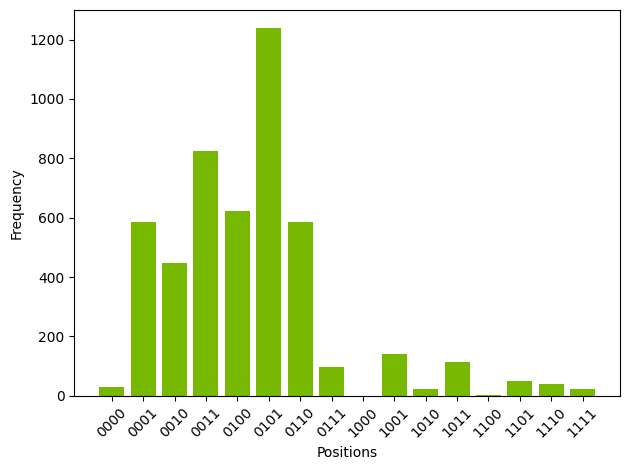

The expectation value <ψ|H|ψ>  using parameters (0.822406, 0.805537, and 2.855993), is 3.00332605398224 


In [4]:
# Set a variable for the number of time steps
num_time_steps = 6

# Pick your favorite values
# Proudly picked the perfect three numbers
# All three params need to be in bounds [-pi, pi]
theta = np.pi/3.82    #CHANGE ME
phi = np.pi/3.9   #CHANGE ME
lam = np.pi/1.1     #CHANGE ME

# Set the number of position qubits
num_qubits = 4

@cudaq.kernel()
def DTQW_for_expectation_value_computation(num_qubits: int, parameters : list[float], num_time_steps : int):
    walker_qubits = cudaq.qvector(num_qubits)
    coin_qubit = cudaq.qvector(1)

    theta = parameters[0]
    phi = parameters[1]
    lam = parameters[2]

    # Initial walker state |9> = |1001> for possibly faster convergence
    #x(walker_qubits[3])
    #x(walker_qubits[2])

    # initial coin state
    h(coin_qubit[0])

    #for i in range(1, num_qubits):
    #    x.ctrl(walker_qubits[0], walker_qubits[i])

    # Flip the coin num_time_steps and shift the walker accordingly
    for _ in range(num_time_steps):

        # One quantum walk step
        # Coin operation F=u3
        u3(theta, phi, lam, coin_qubit)

        # Walker's position change
        # Shift right (S+) when the coin is |1>
        cudaq.control(INC, coin_qubit[0], walker_qubits)

        # Shift left (S-) when the coin is |0>

        x(coin_qubit[0])
        cudaq.control(DEC, coin_qubit[0], walker_qubits)
        x(coin_qubit[0])

# Sample the kernel for the quantum walk
result_aiming_for_mean_of_3 = cudaq.sample(DTQW_for_expectation_value_computation, num_qubits, [theta, phi, lam], num_time_steps, shots_count=10000)
print('sampling results with the coin qubit:', result_aiming_for_mean_of_3)


# Define a function to draw the histogram of the results ignoring the coin qubit

def plot_results_without_coin_qubit(result, num_qubits):
    # Define a dictionary of results

    # Function to convert binary string to integer
    def binary_to_int(binary_string):
        return int(binary_string, 2)
    # Initialize the dictionary with all possible bit strings of length 4 for the x axis
    result_dictionary = {}

    # Generate all possible bit strings of length num_qubits
    for i in range(2**num_qubits):
        bitstr = bin(i)[2:].zfill(num_qubits)
        result_dictionary[bitstr] = 0

    # Update the results dictionary of results from the circuit sampling
    for k,v in result.items():
        k_without_coin = k[:-1]
        result_dictionary[k_without_coin] = v

    # Convert the dictionary to lists for x and y values
    x = list(result_dictionary.keys())
    y = list(result_dictionary.values())

    # Create the histogram
    plt.xlabel("Positions")
    plt.ylabel("Frequency")

    # Create the histogram
    plt.bar(x, y, color='#76B900')

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()


# Draw the histogram of the results after one step
plot_results_without_coin_qubit(result_aiming_for_mean_of_3, num_qubits)

# Compute the expectation value
exp_value = cudaq.observe(DTQW_for_expectation_value_computation, position_hamiltonian, num_qubits, [theta, phi, lam], num_time_steps).expectation()
print('The expectation value <ψ|H|ψ>  using parameters ({:.6f}, {:.6f}, and {:.6f}), is {} '.format(theta, phi, lam, exp_value))

---
## **Section 4** Identify Parameters to Generate a Targeted Mean Value

  We have now arrived at the need for the variational quantum algorithm (see the diagram below). We can iniatilize the kernel with some parameter values, and then turn the problem over to a classical optimizer to search for new parameter values that minimize a cost function (sometimes referred to as an error function).  In our case we want to minimize the difference between $\bra{\psi_W} H\ket{\psi_W}$ and our targeted mean of $3$.  For the cost function, we'll use the mean square error (MSE) as our metric for closeness between the expecatation value and the targeted mean.
  
  <img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/dtqw-diagram.png" alt="image of a quantum circuit with the three partsL encode information, manipulate quantum states, extract information" width="700"/>
  
  

The code block below defines the cost function and creates a list to record its values at each iteration of the loop.

In [5]:
# Create a list to store the cost values from each iteration of the variational algorithm
cost_values = []

# Compute the cost for a given set of parameters
def cost(parameters):
    """Returns the MSE between the targeted mean of 3 and the expectation value of the DTQW as our cost,
    which we want to minimize. The cost for the given parameters is stored in the cost_values list.
    Parameters
        parameters : list[float] The parameters to be optimized
    Returns
        cost_val : float The cost value
    """
    # Compute the expectation value
    expectation_value = cudaq.observe(DTQW_for_expectation_value_computation, position_hamiltonian, num_qubits, parameters, num_time_steps, shots_count = 50000).expectation()
    # Compute the cost value
    cost_val = np.sqrt((expectation_value-3)**2)
    cost_values.append(cost_val)
    return cost_val

Below we use our built-in optimization suite (`cudaq.optimizers`) to minimize the cost function. Specifically, we will select the gradient-free Nelder Mead classical optimization alogrithm.

In [6]:
# Define a CUDA-Q optimizer
optimizer = cudaq.optimizers.NelderMead()

# Set initial parameter values
optimizer.initial_parameters = [theta, phi, lam]

# Optimize the cost function
# The optimizer will try to minimize the cost function defined above
result = optimizer.optimize(dimensions=3, function=cost) #dimensions is the number of parameter values

print('The minimal cost found is ',result[0])
print('The optimized parameters are ',result[1])

The minimal cost found is  1.9999999999686935e-05
The optimized parameters are  [0.822838602822322, 0.819324092059676, 2.861471870623789]


Let's plot the cost values for each iteration of the variational algorithm to see the the convergence.

Text(0, 0.5, 'Cost Value')

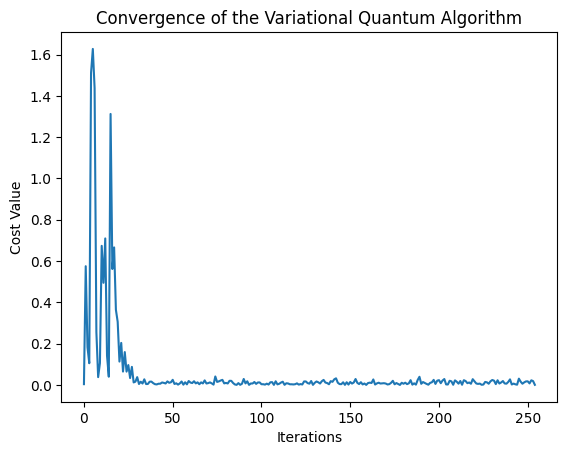

In [7]:

# Plotting how the value of the cost function decreases during the minimization procedure.
plt.title("Convergence of the Variational Quantum Algorithm")
x_values = list(range(len(cost_values)))
y_values = cost_values

plt.plot(x_values, y_values)

plt.xlabel("Iterations")
plt.ylabel("Cost Value")

Finally, let's use the optimal parameters to carry out the DTQW to verify that we have generated a probability distribution with a mean close to 3.

sampling results with the coin qubit: { 00000:3617 00001:22 00010:116 00011:569 00100:784 00101:512 00110:117 00111:827 01000:21 01001:646 01011:1203 01101:630 01110:102 10010:148 10101:26 10110:106 11000:4 11001:21 11010:57 11011:23 11101:27 11110:392 11111:30 }



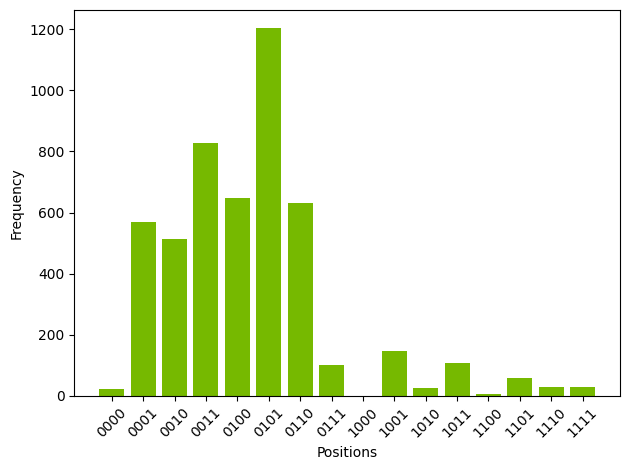

The expectation value  <ψ|H|ψ>  is  2.997393383718202


In [8]:
optimal_parameters = result[1]
result_optimized = cudaq.sample(DTQW_for_expectation_value_computation, num_qubits, optimal_parameters, num_time_steps, shots_count=10000)
print('sampling results with the coin qubit:', result_optimized)

# Draw the histogram of the results after one step
plot_results_without_coin_qubit(result_optimized, num_qubits)

# Compute the expectation value
exp_value = cudaq.observe(DTQW_for_expectation_value_computation, position_hamiltonian, num_qubits, optimal_parameters, num_time_steps).expectation()
print('The expectation value  <ψ|H|ψ>  is ',exp_value)

---
## Completion of the Quick Start to Quantum Computing Series

Congratulations! You've successfully written your first variational quantum algorithm. You're now prepared to explore more advanced examples and applications.

**Additional Challenges and Exercises**

To further develop your skills, consider the following problems:

1. **Parameterized DTQW**: Modify the existing DTQW code to incorporate different parameters in the coin flip operation `u3` at each step. In other words each step of the DTQW might have a different coin operator.  You can build upon the code developed in Lab 3 and 4.
2. **Targeted Distribution Generation**: Adapt the variational algorithm to generate a targeted distribution. To do this, you will need to sample the distribution at each stage and use the mean square error between the sampled distribution and the targeted distribution as your cost function. Hint: For this problem, you will use the `sample` command instead of the `observe` command and you will not need to define a Hamiltonian.
3. **Varying the quantum walk**: Consider variations to the DTQW by introducing an additional coin flip in between steps right and left (i.e., between the controlled-`INC` and controlled-`DEC` operations).  

The animation below demonstrates what is possible by solving problems 1-3 above to model financial data:

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/quantum_walk_target.gif" alt="animation of a optimizing a quantum walk to target a log-normal  " width="400"/>


**Future Directions and Resources**

Now that you have a solid foundation in variational quantum algorithms, you can explore more advanced topics and applications, including:

* **[Multi-split-step quantum walk for financial data](https://arxiv.org/pdf/2302.12500)**: Apply the variational quantum algorithm template to generate probability distributions for financial data.  You can learn more about this example in [notebooks 1](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/01_quantum_walks.ipynb) and [2](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/02_quantum_walks.ipynb) of the the CUDA-Q Academic [Quantum Applications to Finance series](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/READ_ME.md).
* **[Quantum Approximate Optimization Algorithm (QAOA)](https://github.com/NVIDIA/cuda-q-academic/tree/main/qaoa-for-max-cut)**: Learn about QAOA, circuit cutting, and GPU acceleration as applied to the max cut optimization problem.
* **[Variational Quantum Eigensolver (VQE)](https://nvidia.github.io/cuda-quantum/latest/applications/python/vqe_advanced.html)**: Discover how VQE can be used to find the ground state of a quantum system.
* **[Hybrid quantum neural networks](https://nvidia.github.io/cuda-quantum/latest/applications/python/hybrid_qnns.html)**: Explore the intersection of quantum computing and machine learning.

To take your quantum computing skills to the next level, consider learning about accelerating quantum computing and expanding simulation capabilities. The [Accelerating Quantum Computing: A Step-by-Step Guide](https://github.com/NVIDIA/cuda-q-academic/blob/main/Guide-to-cuda-q-backends.ipynb) provides a comprehensive resource to help you achieve this goal.
